In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pathlib

# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = pathlib.Path.home() / 'data/dog-breeds'
image_size = 224
batch_size = 58

In [5]:
# choose arch
# resnet34 -> resnext50 -> resnext101_64
arch = resnext101_64

def get_data(image_size, batch_size):
    # configure transforms
    tfms = tfms_from_model(arch, image_size, aug_tfms=transforms_side_on, max_zoom=1.1)

    # create the image classifier data source
    # base directory is PATH, training labels are contained in the CSV
    data = ImageClassifierData.from_csv(
        PATH, 'train', str(PATH / 'labels.csv'), 
        tfms=tfms,
        suffix='.jpg', test_name='test',
        bs=batch_size, num_workers=4
    )
    
    return data if image_size > 300 else data.resize(340, 'tmp')

data = get_data(image_size, batch_size)

# create our learner
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=.5)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 70%|██████▉   | 98/141 [00:02<00:01, 41.08it/s, loss=14.5]


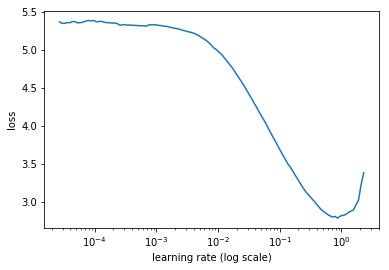

In [6]:
# find our optimal learning rate
lrf = learn.lr_find()
learn.sched.plot()

In [7]:
lr = 1e-1

# train for 3 epoch
learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.685357   0.297407   0.898399  
    1      0.416933   0.273584   0.906541                    



[0.27358422, 0.9065407779481676]

In [8]:
# stop using the pre-computed samples and switch to data augmentation
# train for 5 epochs
learn.precompute = False
learn.fit(lr, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.408812   0.250969   0.922414  
    1      0.367048   0.253552   0.918103                    
    2      0.346356   0.256486   0.926724                    
    3      0.308481   0.252124   0.927682                    
    4      0.307449   0.245004   0.921456                    



[0.24500418, 0.9214559445778528]

In [9]:
# reset the data with a larger size
# we can do this on any fully-convolutional architecture
learn.set_data(get_data(299, batch_size))

# train for 3 more cycles, restart every epoch
learn.fit(lr, 3, cycle_len=1)

# in both of the last training round, we observed train_loss < val_loss.
# model is starting to overfit.  we see if we can eek out any more
# performanc by training with increasing cycles.  turns out we just overfit.
# 
# train for 3 more cycles, doubling cycle length, restarting every cycle
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.29197    0.250289   0.919061  
    1      0.278167   0.265038   0.920977                    
    2      0.246537   0.260656   0.922893                    



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.238052   0.255756   0.920977  
    1      0.24247    0.276223   0.912835                    
    2      0.177392   0.257207   0.919061                    
    3      0.216963   0.302486   0.918582                    
    4      0.221957   0.274581   0.917625                    
    5      0.146626   0.267811   0.922414                    
    6      0.130289   0.26098    0.921456                    



[0.26098, 0.9214559396107992]

In [ ]:
# save our model
learn.save('299_all_50')

In [ ]:
# load our model back
learn.load('299_all_50')

In [ ]:
# unfreeze the other layers (but not the batch-norm ones)
# train differential learning rates for different layers
# for 3 restarts with increasing cycle len
learn.unfreeze()
learn.bn_freeze(True)

# find our new optimal learning rate
lrf = learn.lr_find()
learn.sched.plot()

In [ ]:
# train till overfit.
#
# but since this data is actually sampled from imagenet, we don't observe any 
# improvement from additional cycles.  but throwing some in for good measure.
lr = np.array([1e-7, 1e-6, 1e-5])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
# test-time augmentation predictions
log_preds, y = learn.TTA()

# compute probabilities and result
probs = np.mean(np.exp(log_preds), axis=0)
metrics.log_loss(y, probs), accuracy_np(probs, y)

In [ ]:
from sklearn.metrics import confusion_matrix

# plot the confusion matrix
preds = np.argmax(probs, axis=1)
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes, figsize=(50,50))